In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from astropy.io import fits

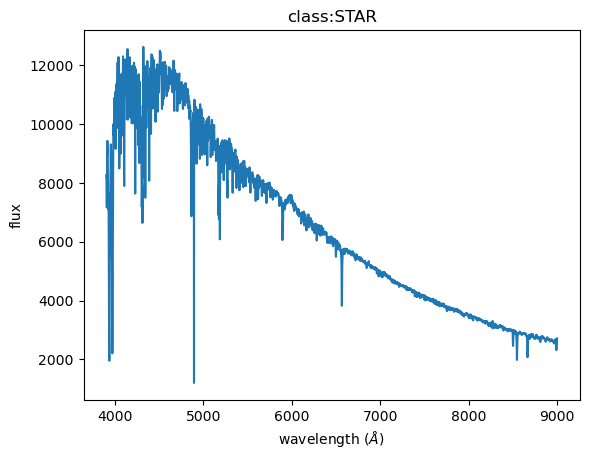

In [18]:
hdulist = fits.open('./output/train_data_05.fits')
num = 5001 # the 5001st spectra in this fits file

flux = hdulist[0].data[num-1]
objid = hdulist[1].data['objid'][num-1]
label = hdulist[1].data['label'][num-1]
wavelength = np.linspace(3900,9000,3000)

c = {0:'GALAXY',1:'QSO',2:'STAR'}
plt.plot(wavelength,flux)
plt.title(f'class:{c[label]}')
plt.xlabel('wavelength ({})'.format(f'$\AA$'))
plt.ylabel('flux')
plt.show()

# 1. 初探

In [19]:
# 把所有的光谱数据都加载进来
flux = []
label = []
for i in range(1, 11):
    if i < 10:
        data_path = f'./output/train_data_0{i}.fits'
    else:
        data_path = './output/train_data_10.fits'
    hdulist = fits.open(data_path)
    for f in hdulist[0].data:
        flux.append(f)
    for l in hdulist[1].data['label']:
        label.append(l)

print(len(flux))
print(len(label))

100000
100000


观察一下三种星体的数据分布

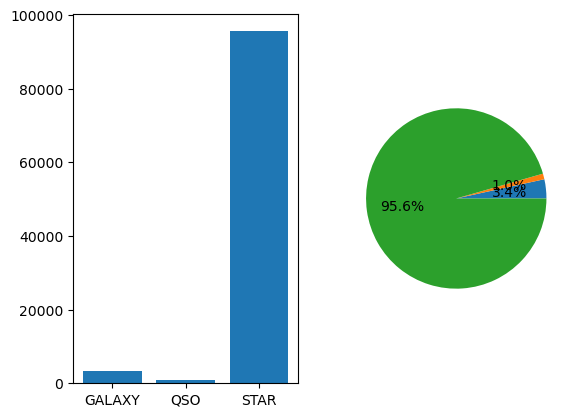

In [20]:
star_cnt = 0
galaxy_cnt = 0
qso_cnt = 0
for l in label:
    if l == 0:
        galaxy_cnt += 1
    elif l == 1:
        qso_cnt += 1
    elif l == 2:
        star_cnt += 1
x = np.array(['GALAXY', 'QSO', 'STAR'])
y = np.array([galaxy_cnt, qso_cnt, star_cnt])
plt.subplot(1, 2, 1)
plt.bar(x, y)
plt.subplot(1, 2, 2)
plt.pie(y, autopct='%1.1f%%')
plt.show()

数据分布太不均衡了，需要调整

# 2. 数据预处理

## 2.1. 平衡数据集分布

In [21]:
import random

# 拼接数据
data = []

for i in range(len(flux)):
    data.append([flux[i], label[i]])

In [22]:
data_balanced = []
for d in data:
    if d[1] == 0:
        data_balanced.append(d)     # 星系直接写入
    elif d[1] == 1:
        data_balanced.append(d)
        data_balanced.append(d)
        data_balanced.append(d)     # 类星体写3次
    elif d[1] == 2:
        delta = random.randint(1, 31)
        if delta == 1:
            data_balanced.append(d)     # 恒星数据保留1/30
print(len(data_balanced))

# 重新调整数据集的顺序
random.shuffle(data_balanced)

9521


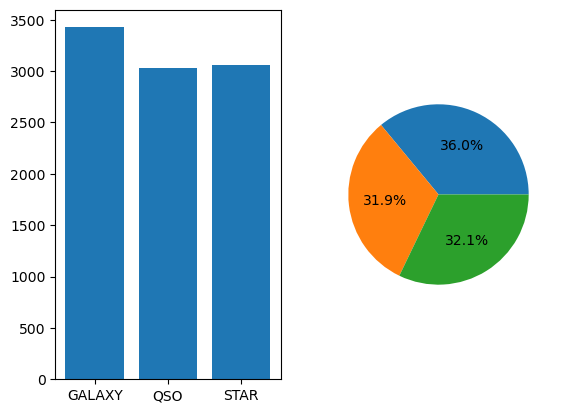

In [23]:
star_cnt = 0
galaxy_cnt = 0
qso_cnt = 0
for d in data_balanced:
    if d[1] == 0:
        galaxy_cnt += 1
    elif d[1] == 1:
        qso_cnt += 1
    elif d[1] == 2:
        star_cnt += 1
x = np.array(['GALAXY', 'QSO', 'STAR'])
y = np.array([galaxy_cnt, qso_cnt, star_cnt])
plt.subplot(1, 2, 1)
plt.bar(x, y)
plt.subplot(1, 2, 2)
plt.pie(y, autopct='%1.1f%%')
plt.show()

根据平衡后的数据划分训练集和测试集

In [24]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data_balanced, transform = None, target_transform = None):
        self.spectrum = data_balanced
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, index):
        flux, label = self.spectrum[index]
        if self.transform is not None:
            flux = self.transform(flux)
        flux = savgol_filter(flux, window_length=7, polyorder=2)    ## 滤波
        Scaler1 = MinMaxScaler()
        flux = flux.reshape(-1, 1)
        flux = Scaler1.fit_transform(flux)
        flux = flux.reshape(1, -1)
        # label = label - 1
        return flux, label
    
    def __len__(self):
        return len(self.spectrum)

In [25]:
train_data = MyDataset(data_balanced[:8500])
val_data = MyDataset(data_balanced[8501:])
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=32, shuffle=True)

现在已经成功将训练集和验证集加载到torch当中

# 3. 搭建神经网络结构

In [26]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 5)
        self.fc1 = nn.Linear(32*372, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  ## 展平
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)

        return output

In [27]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)
model = MyNet().to(device)
model.double()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


# 4. 定义训练函数

In [28]:
def train_runner(model, device, train_loader, optimizer, epoch):
    model.train()
    total = 0
    correct = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 初始化梯度
        optimizer.zero_grad()
        # 保存训练结果
        outputs = model(inputs)
        # 计算损失和，交叉熵损失
        loss = F.cross_entropy(outputs, labels)

        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()

        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()

        if i % 100 == 0:
            print('Train Epoch{} \t Loss : {:.6f}, accuracy : {:.6f}%'.format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)

    return loss.item(), correct/total

# 5. 定义测试函数

In [29]:
def test_runner(model, device, val_loader):
    model.eval()
    correct = 0.0
    test_loss = 0.0
    total = 0

    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            total += label.size(0)
            correct += (predict == label).sum().item()

        print('test_average_loss: {:.6f}, accuracy: {:.6f}%'.format(test_loss/total, 100*(correct/total)))

# 6. 运行

In [30]:
epoch = 5
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print('start_time: ', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    loss, acc = train_runner(model, device, train_loader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, val_loader)
    print('end_time: ', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), '\n')

start_time:  2024-05-05 23:27:24
Train Epoch1 	 Loss : 1.110296, accuracy : 18.750000%
Train Epoch1 	 Loss : 0.397819, accuracy : 58.539604%
Train Epoch1 	 Loss : 0.274224, accuracy : 69.651741%
test_average_loss: 0.009388, accuracy: 88.823529%
end_time:  2024-05-05 23:27:37 

start_time:  2024-05-05 23:27:37
Train Epoch2 	 Loss : 0.139884, accuracy : 93.750000%
Train Epoch2 	 Loss : 0.227838, accuracy : 89.170792%
Train Epoch2 	 Loss : 0.036320, accuracy : 90.640547%
test_average_loss: 0.005449, accuracy: 93.235294%
end_time:  2024-05-05 23:27:50 

start_time:  2024-05-05 23:27:50
Train Epoch3 	 Loss : 0.348754, accuracy : 90.625000%
Train Epoch3 	 Loss : 0.158788, accuracy : 92.048267%
Train Epoch3 	 Loss : 0.093985, accuracy : 93.190299%
test_average_loss: 0.005120, accuracy: 94.117647%
end_time:  2024-05-05 23:28:03 

start_time:  2024-05-05 23:28:03
Train Epoch4 	 Loss : 0.295379, accuracy : 84.375000%
Train Epoch4 	 Loss : 0.173776, accuracy : 94.183168%
Train Epoch4 	 Loss : 0.1

# 7. Inference

In [37]:
import csv

# 加载测试集
data_test = []
test_path = './output/test_data.fits'
hdulist = fits.open(data_path)

flux = []
label = []
objid = []

for f in hdulist[0].data:
    flux.append(f)
for o in hdulist[1].data['objid']:
    objid.append(o)
    label.append(1)

for i in range(len(flux)):
    data_test.append([flux[i], label[i]])

test_data = MyDataset(data_test)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# 这里感觉有问题，但是暂时想不到更好的inference了
idx = 0
with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            predict = output.argmax(dim=1)
            ob = objid[idx]
            idx += 1

            # print(predict[0].item())

            with open('./inference_output.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                if f.tell() == 0:   # 检查文件是否为空
                    writer.writerow(['obj_id', 'predicted_label'])
                writer.writerow([ob, predict[0].item()])
